# Pricing : excess of rain cover

In [1]:
%load_ext nb_black
from pathlib import Path
import pandas as pd
import numpy as np
import xarray as xr
from numpy.testing import assert_allclose
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

# Context

A client is looking to be covered against excess of rain.

You will first manipulate rasters and then use historical data to understand the risk.

# 1. Parameters

In [2]:
DATA_PATH = Path("data")
RASTERS_PATH = DATA_PATH / "rasters"

<IPython.core.display.Javascript object>

# 2. Data

## 2.1 Load data

In [3]:
vegetation_path = RASTERS_PATH / "vegetation.nc"
precipitation_path = RASTERS_PATH / "precipitation.nc"

<IPython.core.display.Javascript object>

In [4]:
vegetation_xr = xr.load_dataset(vegetation_path)
precipitation_xr = xr.load_dataset(precipitation_path)

<IPython.core.display.Javascript object>

## 2.2 Visualize data

Let's look at the coordinates values:

In [5]:
print(vegetation_xr.latitude.values[:2])

[-4755784.4062485 -4756034.4062485]


<IPython.core.display.Javascript object>

The coordinate reference system (crs) here is named an equal-area crs which means that the areas are preserved when projecting the earth to a plane. The unit of the coordinates is **meters**. See more info [there](https://en.wikipedia.org/wiki/Spatial_reference_system).

In [6]:
precipitation_xr

<xarray.Dataset>
Dimensions:        (longitude: 48, latitude: 48, time: 26433)
Coordinates:
    spatial_ref    int64 0
  * longitude      (longitude) float64 1.275e+06 1.276e+06 ... 1.28e+06 1.28e+06
  * latitude       (latitude) float64 -4.756e+06 -4.756e+06 ... -4.76e+06
  * time           (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2022-05-15
Data variables:
    precipitation  (latitude, longitude, time) float32 0.0 0.0 0.0 ... 0.0 0.0

<IPython.core.display.Javascript object>

One can notice that the precipitation raster has time variable. We then have access of cumulative daily precipitation data since the 1st of January 1950

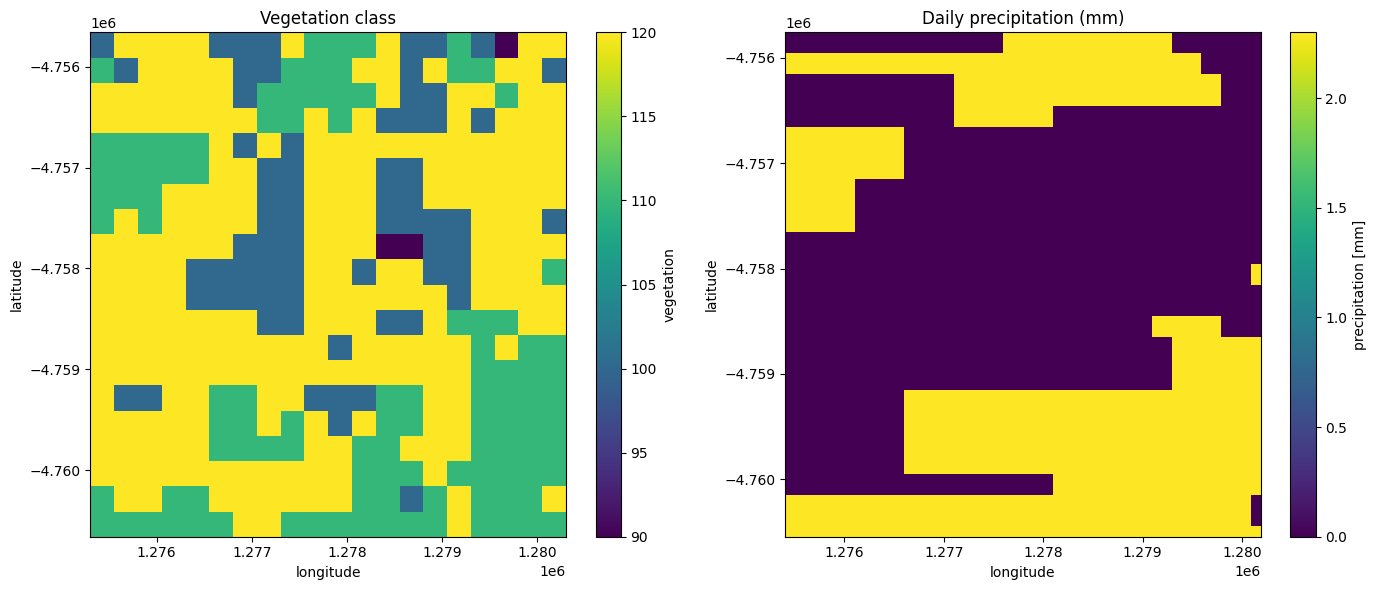

<IPython.core.display.Javascript object>

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
vegetation_xr.vegetation.plot(ax=ax[0])
ax[0].set_title("Vegetation class")
precipitation_xr.precipitation[dict(time=3)].plot(ax=ax[1])
ax[1].set_title("Daily precipitation (mm)")
ax[1].set_xlabel("longitude")
ax[1].set_ylabel("latitude")
plt.tight_layout()
plt.show()

The vegetation raster is a gridded array of categorical values with information on the type of the dominant vegetation of each pixel.

    - Class 90 : Water and urban areas
    - Class 100: Herbaceous class
    - Class 110: Forest class
    - Class 120: Shrubland class
    
For example, the pixel at location (longitude 1277929.24, latitude -4758284.41) displays a value of 120, meaning that the vegetation at this location is shrubland.

#### What is each raster's resolution (in meters)?

The resolution is defined as the distance between the centres of 2 neighbour pixels.

In [8]:
# the pixels are well aligned on the x and y axis so the distance is just the absolute value of the differences between consecutive pixels
# we verify that resolution is approximately the same along both axes
vegetation_resolution = int(abs(vegetation_xr.latitude.diff(dim="latitude").mean()))
precipitation_resolution = int(abs(precipitation_xr.latitude.diff(dim="latitude").mean())) # rounds to the smallest integer

print(f"The vegetation resolution is {vegetation_resolution} meters")
print(f"The precipitation resolution is {precipitation_resolution} meters")

The vegetation resolution is 250 meters
The precipitation resolution is 99 meters


<IPython.core.display.Javascript object>

This is coherent with the previous figure, where we can see that the size of individual pixels in the vegetation raster are bigger than those in the precipitation raster.

In [9]:
assert isinstance(vegetation_resolution, int)
assert isinstance(precipitation_resolution, int)

<IPython.core.display.Javascript object>

# 3. Manipulate rasters

### 3.1 Change rasters' resolution

Your task is to get the precipitation for all grid cells in the forest class (value of 110). Unfortunately, the 2 rasters do not have the same resolution. Your task will be to reindex the 2 rasters at the **same** resolution.

The resolution of each raster should be the finest one out of the 2 intial datasets.

To downscale (move from coarse to finer resolution), you will use the function `xarray.interp()`: https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interp.html

In [10]:
# We downscale only the coarser raster i.e the vegetation one
vegetation_downscaled_xr = vegetation_xr.interp(
    longitude=precipitation_xr.longitude.values, 
    latitude=precipitation_xr.latitude.values,
    method="nearest"
)
precipitation_downscaled_xr = precipitation_xr.copy()

<IPython.core.display.Javascript object>

Since the vegetation raster contains categorical data about the type of vegetation in each location, we can not use the default interpolation method "linear" in xarray.interp() because it would introduce float values which did not exist in the original raster. For that reason, we use the "nearest" method which uses the nearest neighbor in the original raster to determine the new class.

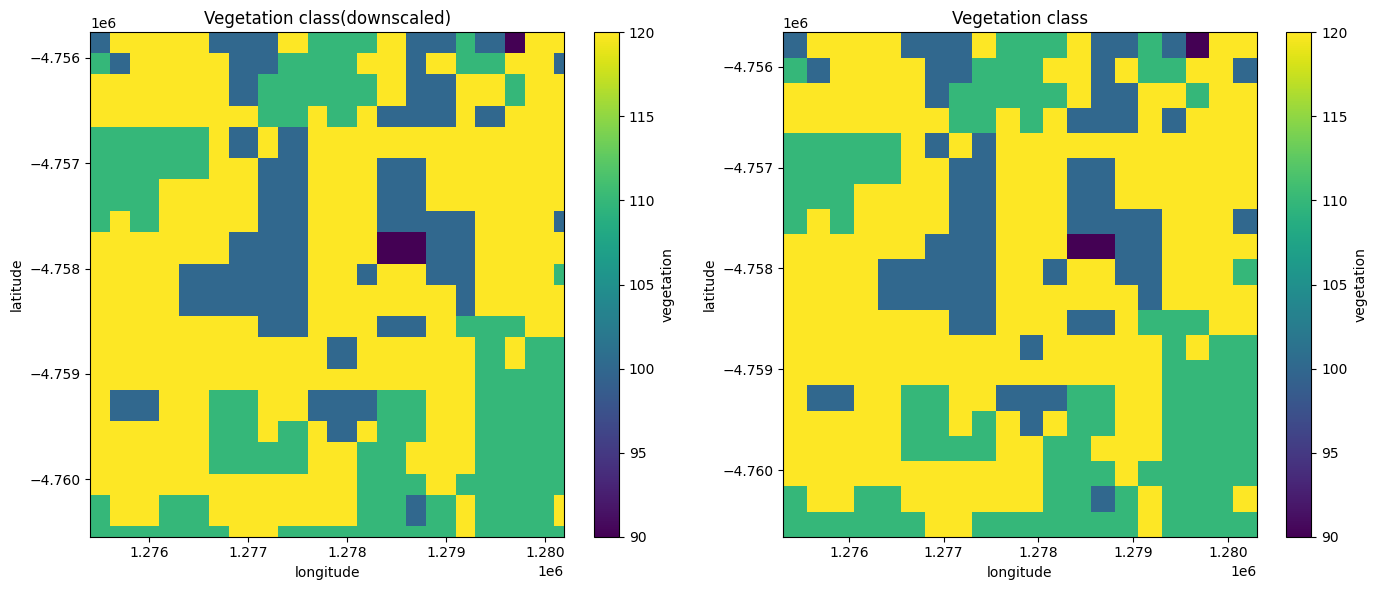

<IPython.core.display.Javascript object>

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
vegetation_downscaled_xr.vegetation.plot(ax=ax[0])
ax[0].set_title("Vegetation class(downscaled)")
vegetation_xr.vegetation.plot(ax=ax[1])
ax[1].set_title("Vegetation class")
ax[1].set_xlabel("longitude")
ax[1].set_ylabel("latitude")
plt.tight_layout()
plt.show()

In [12]:
assert isinstance(vegetation_downscaled_xr, xr.Dataset)
assert isinstance(precipitation_downscaled_xr, xr.Dataset)

<IPython.core.display.Javascript object>

## 3.2 Compute mean precipitation

The client has forests that span over all the area showed by the raster, which means that all grid cells in forest class belong to the client.

**Task**

Your task is to compute the mean daily precipitation for grid cells only in **forest class**. You may want to use the function [`xarray.where()`](https://docs.xarray.dev/en/stable/generated/xarray.where.html).

The output will be a dataframe `df_rain_historical` with the dates as index with name `Date` and the column daily precipitation renamed `daily_rain`. You could use the function [`xarray.to_dataframe()`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.to_dataframe.html)

In [13]:
# create a mask for forest areas (vegetation class 110)
forest_mask = vegetation_downscaled_xr.vegetation == 110

# filter precipitation of forest areas
forest_precipitation = precipitation_downscaled_xr.where(forest_mask)

# compute mean daily precipitation, mean over spatial dims latitude and longitude
df_rain_historical = forest_precipitation.mean(dim=['latitude', 'longitude'], skipna=True).to_dataframe()

# drop the spatial_ref column from the resulting df
df_rain_historical.drop(columns='spatial_ref', inplace=True)

# rename the precipitation column and index
df_rain_historical.rename(columns={'precipitation': 'daily_rain'}, inplace=True)
df_rain_historical.index.rename('Date', inplace=True)
df_rain_historical

,daily_rain
Date,
1950-01-01,0.000000
1950-01-02,0.000000
1950-01-03,5.899972
1950-01-04,2.300004
1950-01-05,0.000000
...,...
2022-05-11,20.099937
2022-05-12,7.199967
2022-05-13,24.799871


<IPython.core.display.Javascript object>

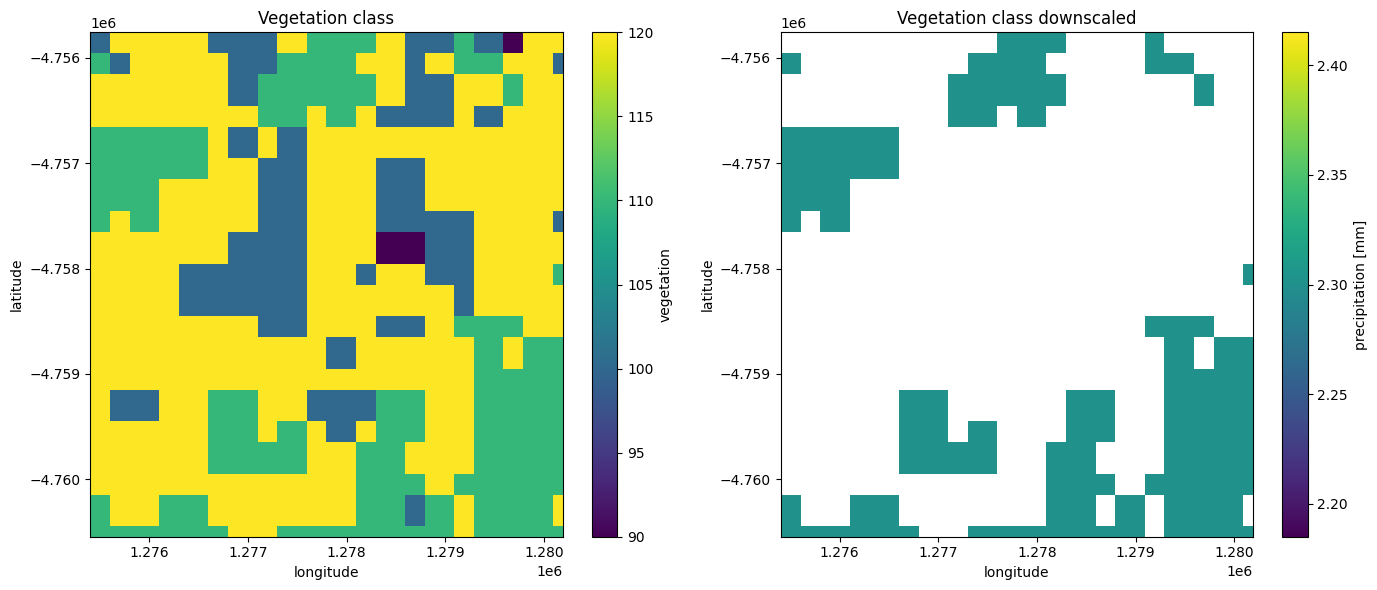

<IPython.core.display.Javascript object>

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
vegetation_downscaled_xr.vegetation.plot(ax=ax[0])
ax[0].set_title("Vegetation class")
forest_precipitation.precipitation[dict(time=3)].plot(ax=ax[1])
ax[1].set_title("Precipitation (mm)")
ax[1].set_xlabel("longitude")
ax[1].set_ylabel("latitude")
plt.tight_layout()
plt.show()

The values seem reasonable for a palce like Australia which is known for its dry weather.

In [15]:
assert df_rain_historical.index.name == "Date"

<IPython.core.display.Javascript object>

## 3.3 Next steps

The previous task helped you to compute the daily precipitation for one day at the client's locations. We actually have access to 70 years of historical data and that's the object of the next steps. The data from the previous part has been extracted at the client location into a dataframe that you will use from now on

# 4. Pricing

## 4.1 Context

The client is looking to be covered against excess of rain.

The client wishes to receive a payout under the following conditions:
+ Depends on the cumulative rainfall (mm) over the season.
+ Linear payout starting at a deductible of 650 mm and limit of 750 mm with a payout of AUD 500,000.

It means that 
+ If the cumulative rainfall is below 650 mm, the client receives nothing.
+ If the cumulative rainfall is above 750 mm, the client receives the max payout of AUD 500,000 no matter the loss.
+ If the cumulative rainfall is between 650 and 750 mm, the payout is linear, slope of AUD 5,000 per mm. For example, if the cumulative rainfall is 700 mm, the payout would be AUD 250,000.


## 4.2 Data

We have access to the cumulative rainfall (in millimeters-mm) each day since 1950 January 1st using the task before.

## 4.3 Preprocessing

### 4.3.1 Filtering

**Risk period**

The client would like to be covered from the 1st of December of a given year until 1st of March of the following year (**not included**).

**Task**
- Filter the historical dates to keep only the ones in the risk periods. ⚠️ You should not have incomplete seasons. ⚠️
- Remove the rows with the date equal to February 29th.
- Create a `season` column, the value of the season is the year corresponding to the 1st of December. For example, for the given risk period 1st of December 2021 - 1st of March 2022, the season is 2021.

In [16]:
# filter dates to only risk periods i.e from 1st of December to 1st of March
df_rain_historical = df_rain_historical[
    (df_rain_historical.index.month == 12) | # December
    (df_rain_historical.index.month <= 2)    # January and February
    ].copy()

# remove February 29th (leap day)
df_rain_historical = df_rain_historical[~((df_rain_historical.index.month == 2) & (df_rain_historical.index.day == 29))]

# create the "season" column
df_rain_historical['season'] = df_rain_historical.index.year
df_rain_historical.loc[df_rain_historical.index.month <= 2, 'season'] -= 1

# ensure that seasons are complete i.e they have exactly 90 days
df_rain_historical = df_rain_historical.groupby('season').filter(lambda group : len(group) == 90)
df_rain_historical

,daily_rain,season
Date,,
1950-12-01,0.099999,1950
1950-12-02,0.099999,1950
1950-12-03,0.199999,1950
1950-12-04,0.199999,1950
1950-12-05,16.799904,1950
...,...,...
2022-02-24,0.000000,2021
2022-02-25,1.599992,2021
2022-02-26,0.000000,2021


<IPython.core.display.Javascript object>

In [17]:
assert list(df_rain_historical.columns) == ["daily_rain", "season"]

<IPython.core.display.Javascript object>

### 4.3.2 Regroup by season

**Task**

- Create a new dataframe `df_cum_rain` by regrouping by season and by computing the cumulative rainfall over the risk period.
- Rename the column `daily_rain` by `cum_rain`.

In [18]:
# group by "season" and use cumsum() from pandas.DataFrame to calculate the cumulative rainfall
df_cum_rain = df_rain_historical.groupby('season')['daily_rain'].cumsum().reset_index()

# rename the column daily_rain to cum_rain
df_cum_rain.rename(columns={'daily_rain': 'cum_rain'}, inplace=True)

# set Date as the index
df_cum_rain = df_cum_rain.set_index('Date', drop=True)
df_cum_rain

,cum_rain
Date,
1950-12-01,0.099999
1950-12-02,0.199999
1950-12-03,0.399998
1950-12-04,0.599997
1950-12-05,17.399900
...,...
2022-02-24,145.000443
2022-02-25,146.600433
2022-02-26,146.600433


<IPython.core.display.Javascript object>

## 4.4 Compute payouts

Using the current values of `cum_rain`, we will now compute the historical payouts.

**Task**
- Design a function that computes the payouts using the structure defined above.
- Compute historical payouts since 1950 by creating a new dataframe `df_historical_payouts` with column `hist_payouts`. 

The resulting mean value of historical payouts is called **burning cost** and corresponds to the mean payout the client would have received based on the historica data. This is an important metrics in the design of insurance covers.

In [19]:
def calculate_payout(cum_rain: float) -> float:
    """Calculates payout based on daily cumulative rainfall."""
    lower = 650
    upper = 750
    max_payout = 500_000
    slope = 5_000

    if cum_rain <= lower:
        return 0
    elif cum_rain >= upper:
        return max_payout
    else:
        return (cum_rain - lower) * slope

# apply the calculate_payout function and name the resulting column hist_payouts
df_historical_payouts = df_cum_rain['cum_rain'].apply(calculate_payout).to_frame(name='hist_payouts')
df_historical_payouts

,hist_payouts
Date,
1950-12-01,0.0
1950-12-02,0.0
1950-12-03,0.0
1950-12-04,0.0
1950-12-05,0.0
...,...
2022-02-24,0.0
2022-02-25,0.0
2022-02-26,0.0


<IPython.core.display.Javascript object>

First of all, the fact that we have mostly zero payouts makes sense. Excessive rainfalls are rare in general especially in a palce like Australia which is known for its arid weather. This is a good sanity check.

In [20]:
print(f"The burning cost is at around {df_historical_payouts.mean().item():.2f} AUD.")

The burning cost is at around 8917.19 AUD.


<IPython.core.display.Javascript object>

## 4.5 Weighting

### 4.5.1 Year type

We actually have access to historical yearly forecasts that states if the year was supposed to be rainy or not. There are 3 predictions:
- neutral
- dry
- rainy

All the information is stored in the dataframe `df_year_type`.

We will use this information to compute a weighted payouts using next year forecast.

In [21]:
year_type_data_path = DATA_PATH / "pricing" / "year_type_historical.csv"

<IPython.core.display.Javascript object>

In [22]:
df_year_type = (
    pd.read_csv(year_type_data_path, index_col=0)
    .rename(columns={"Year": "season"})
    .set_index("season")
)
df_year_type.head()

,year_type
season,
1950,rainy
1951,dry
1952,neutral
1953,dry
1954,rainy


<IPython.core.display.Javascript object>

**Task**

Do the same computation (historical payouts) for each of the year type (rainy, dry or neutral). Compute the burning cost of each of the year type. What can you observe ?

In [23]:
# merge rain and year type data
df_rain_forecast = df_rain_historical.merge(df_year_type, on='season')

# calculate cumulative rainfall
df_rain_forecast['cum_rain'] = df_rain_forecast.groupby('season')['daily_rain'].cumsum()

# calculate payouts
df_rain_forecast['payout'] = df_rain_forecast['cum_rain'].apply(calculate_payout)

# group by year_type and calculate burning cost for each type of year
df_yearly_payouts = df_rain_forecast.groupby('year_type')['payout'].mean().to_frame(name='burning_cost')
df_yearly_payouts

,burning_cost
year_type,
dry,0.000000
neutral,16538.326687
rainy,12141.096578


<IPython.core.display.Javascript object>

For dry years, the burning cost is 0, indicating that the cumulative rainfall did not reach the lower limit of 650 mm required to trigger a payout. Consequently, the client has, on average, received no payouts during these years. For neutral years, the burning cost is observed to be the highest among the three types of years. Interestingly, in rainy years, the burning cost is lower than that in neutral years.

This might initially appear counter-intuitive, but it could be a hit to the methodology used for the classification of years. For example, if the classification was based solely on average rainfall, this could hide those few anomalous days where the rainfall exceeded the upper limit, triggering maximum payouts thus leading to higher burning cost for the neutral years.

### 4.5.2 Next year forecast

The forecast for next year is given in terms of probability for each of the year types:

In [24]:
next_year_forecast = {"dry": 0.58, "neutral": 0.37, "rainy": 0.05}

<IPython.core.display.Javascript object>

**Task**

How would you leverage on these forecasts to better estimate the risk and adjust the burning cost ? 

To estimate the burning cost for next year we can calculate the expected burning cost as follows : 

In [26]:
# convert dataframe to dict
bc_dict = df_yearly_payouts.to_dict()['burning_cost']
print(f"The expected burning cost for next year is : {sum([bc_dict[k] * next_year_forecast[k] for k in bc_dict.keys()]):.2f} AUD")

The expected burning cost for next year is : 6726.24 AUD


<IPython.core.display.Javascript object>

---
# END OF SCRIPT